In [ ]:
#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input,Embedding,LSTM,Dense,GlobalMaxPooling1D,Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [ ]:
%%writefile content.json
{"intents":
 [
  {"tag": "greeting",
         "patterns": ["Hi", "anyone home?", "Is anyone there?", "Hello", "Good day","hey","namste","hola","hey there"],
         "responses": ["Hello, thanks for visiting", "Good to see you again", "Hi there, how can I help?"],
         "context_set": ""
        },
  {"tag": "whoami",
         "patterns": ["who are you?", "What is your name?", "What can I call you?", "who am I talking to?"],
         "responses": ["Hey, I am a Bot called Ivy", "Hey, you can call me Ivy", "I'm Ivy :)"],
         "context_set": ""
        },
  {"tag": "howareyou",
         "patterns": ["How you doing?", "how are you?", "how was your day?", "what's up?", "what are you doing?"],
         "responses": ["I'm doing great, thanks!", "I'm having a great day", "I've never felt better","I'm living my best life"],
         "context_set": ""
        },
   {
            "tag": "jokes",
            "patterns": [
                "Tell me a joke",
                "Joke",
                "Make me laugh"
            ],
            "responses": [
                "A perfectionist walked into a bar...apparently, the bar wasn't set high enough",
                "I ate a clock yesterday, it was very time-consuming",
                "Never criticize someone until you've walked a mile in their shoes. That way, when you criticize them, they won't be able to hear you from that far away. Plus, you'll have their shoes.",
                "The world tongue-twister champion just got arrested. I hear they're gonna give him a really tough sentence.",
                "I own the world's worst thesaurus. Not only is it awful, it's awful.",
                "What did the traffic light say to the car? \"Don't look now, I'm changing.\"",
                "What do you call a snowman with a suntan? A puddle.",
                "How does a penguin build a house? Igloos it together",
                "I went to see the doctor about my short-term memory problems – the first thing he did was make me pay in advance",
                "As I get older and I remember all the people I’ve lost along the way, I think to myself, maybe a career as a tour guide wasn’t for me.",
                "o what if I don't know what 'Armageddon' means? It's not the end of the world."
            ],
            "context": [
                "jokes"
            ]
   },
    {
            "tag": "haha",
            "patterns": [
                "haha",
                "lol",
                "rofl",
                "lmao",
                "thats funny"
            ],
            "responses": [
                "Glad I could make you laugh !"
            ]
        },
    {
            "tag": "insult",
            "patterns": [
                
                "you are dumb",
                
                "shut up",
                "idiot"
            ],
            "responses": [
                "Well that hurts :("
            ]
        },
   {
            "tag": "suggest",
            "patterns": [
                "you are useless","useless","suggest","suggestions","you are bad"
            ],
            "responses": [
                "Please mail your suggestions to ivybot.suggestions@gmail.com. Thank you for helping me improve!"
            ]
        },
        {"tag": "goodbye",
         "patterns": ["Bye", "See you later", "Goodbye","exit",""],
         "responses": ["See you later, thanks for visiting", "Have a nice day", "Bye! Come back again soon."]
        },
        {"tag": "thanks",
         "patterns": ["Thanks", "Thank you", "That's helpful"],
         "responses": ["Happy to help!", "Any time!", "My pleasure"]
        },
        {"tag": "hours",
         "patterns": ["What hours are you open?", "What are your hours?", "When are you open?" ],
         "responses": ["We're open every day 9am-9pm", "Our hours are 9am-9pm every day"]
        },
        {"tag": "cakes",
         "patterns": ["Which cakes do you have?", "What kinds of cakes are there?", "Do you have mango cakes?" , "Do you have vanilla cakes?", "Do you have chocolate cakes?"
         , "Do you have red velvet cakes?"],
         "responses": ["We have Mango, Vanilla, Pineapple ,Chocolate and Red Velvet mopeds", "yes, we do"]
        },
        {"tag": "payments",
         "patterns": ["Do you take credit cards?", "Do you accept Mastercard?", "Are you cash only?" ],
         "responses": ["We accept VISA, Mastercard and AMEX", "We accept most major credit cards"]
        },
        {"tag": "opentoday",
         "patterns": ["Are you open today?", "When do you open today?", "What are your hours today?"],
         "responses": ["We're open every day from 9am-9pm", "Our hours are 9am-9pm every day"]
        },
        {"tag": "order",
         "patterns": ["Can we order a cake?", "I'd like to order a chocolate cake", "I'd like to order a vanilla cake", "I'd like to order a mango cake"
         , "I'd like to order a red velvet cake", "How can I order a cake?" ],
         "responses": ["Are you looking to order right now or sometime later?"],
         "context_set": "ordertime"
        },
        {"tag": "rightnow",
         "patterns": ["right now"],
         "responses": ["For right away orders please call 1-800-cakes", "Same-day orders please call 1-800-cakes"],
         "context_filter": "ordertime"
        },
   {"tag": "later",
         "patterns": ["later this week","not now","some other time"],
         "responses": ["please call 000-800-cakes when you are ready", "You can call 000-800-cakes"],
         "context_filter": "orderday"
        }
 ]
    
}

Overwriting content.json


In [ ]:
#importing the dataset
with open('content.json') as content:
  data1=json.load(content)

In [ ]:
#getting all the data to lists
tags=[]
inputs=[]
responses={}
for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])

In [ ]:
#converting to dataframe
data=pd.DataFrame({"inputs":inputs,"tags":tags})

In [ ]:
data

In [ ]:
#removing punctuations
import string
data['inputs']=data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs']=data['inputs'].apply(lambda wrd:''.join(wrd))
data


,inputs,tags
0,hi,greeting
1,anyone home,greeting
2,is anyone there,greeting
3,hello,greeting
4,good day,greeting
...,...,...
62,how can i order a cake,order
63,right now,rightnow
64,later this week,later
65,not now,later


In [ ]:
#tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
train=tokenizer.texts_to_sequences(data['inputs'])

#apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train=pad_sequences(train)

#encoding the outputs
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y_train=le.fit_transform(data['tags'])

In [ ]:
input_shape=x_train.shape[1]
print(input_shape)

8


In [ ]:
#define vocabulary
vocabulary=len(tokenizer.word_index)
print("number of unique words:",vocabulary)
output_length=le.classes_.shape[0]
print("output length:",output_length)

number of unique words: 90
output length: 16


In [ ]:
#creating the model
i=Input(shape=(input_shape,))
x=Embedding(vocabulary+1,10)(i)
x=LSTM(10,return_sequences=True)(x)
x=Flatten()(x)
x=Dense(output_length,activation="softmax")(x)
model=Model(i,x)

In [ ]:
#compiling the model
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [ ]:
#training the model
train=model.fit(x_train,y_train,epochs=200)

Epoch 1/200
3/3 [==============================] - 2s 7ms/step - loss: 2.7728 - accuracy: 0.0448
Epoch 2/200
3/3 [==============================] - 0s 6ms/step - loss: 2.7692 - accuracy: 0.0896
Epoch 3/200
3/3 [==============================] - 0s 5ms/step - loss: 2.7660 - accuracy: 0.0896
Epoch 4/200
3/3 [==============================] - 0s 6ms/step - loss: 2.7630 - accuracy: 0.1194
Epoch 5/200
3/3 [==============================] - 0s 6ms/step - loss: 2.7596 - accuracy: 0.1791
Epoch 6/200
3/3 [==============================] - 0s 6ms/step - loss: 2.7565 - accuracy: 0.1791
Epoch 7/200
3/3 [==============================] - 0s 5ms/step - loss: 2.7529 - accuracy: 0.1940
Epoch 8/200
3/3 [==============================] - 0s 9ms/step - loss: 2.7493 - accuracy: 0.2388
Epoch 9/200
3/3 [==============================] - 0s 5ms/step - loss: 2.7456 - accuracy: 0.2537
Epoch 10/200
3/3 [==============================] - 0s 6ms/step - loss: 2.7414 - accuracy: 0.3134
Epoch 11/200
3/3 [===========

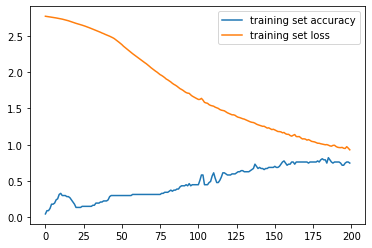

In [ ]:
#plotting model accuracy
plt.plot(train.history['accuracy'],label='training set accuracy')
plt.plot(train.history['loss'],label='training set loss')
plt.legend()

In [ ]:
#chatting
import random
while True:
  texts_p=[]
  prediction_input=input('you:')

  #removing punctuation and converting to lowercase
  prediction_input=[letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input=''.join(prediction_input)
  texts_p.append(prediction_input)

  #tokenizing and padding
  prediction_input=tokenizer.texts_to_sequences(texts_p)
  prediction_input=np.array(prediction_input).reshape(-1)
  prediction_input=pad_sequences([prediction_input],input_shape)

  #getting output from model
  output=model.predict(prediction_input)
  output=output.argmax()

  #finding the right tag and predicting
  response_tag=le.inverse_transform([output])[0]
  print("Bot Ivy:",random.choice(responses[response_tag]))
  if (response_tag=="goodbye"):
    break
  

you:hi
Bot Ivy: Hello, thanks for visiting
you:bye
Bot Ivy: Glad I could make you laugh !
you:Bye
Bot Ivy: Glad I could make you laugh !
you:cake
Bot Ivy: Hello, thanks for visiting


KeyboardInterrupt: ignored